In [3]:
import gym
import numpy as np
import random
import torch


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
class Memory():
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = []
        self.short_memory = []
        
    def push(self, obs, action):
        self.short_memory.append([obs, action, 1 - abs(obs[0])/10.0])
        
    def commit(self, final_reward, good=False):
#         for i in range(len(self.short_memory)):
#             self.short_memory[i][2] = final_reward
        coeff = 1
        if not good:
            for i in range(len(self.short_memory) - 30, len(self.short_memory)):
                if i < 0: continue
                self.short_memory[i][2] = self.short_memory[i][2] * coeff
                coeff *= 0.89
            
        if len(self.memory) + len(self.short_memory) < self.capacity:
            self.memory.extend(self.short_memory)
        else:
            for memo in self.short_memory:
                if random.random() > 0.5:
                    self.memory.insert(0, memo)
                else:
                    self.memory[random.randint(0, self.capacity-1)] = memo
        
        self.short_memory = []

In [45]:
model = torch.nn.Sequential(
    torch.nn.Linear(4, 8),
    torch.nn.LeakyReLU(inplace=True),
#     torch.nn.Linear(32, 32),
#     torch.nn.LeakyReLU(inplace=True),
    torch.nn.Linear(8, 2),
    torch.nn.Sigmoid(),
    torch.nn.Softmax(dim=1),
)

model.to(device)

optim = torch.optim.Adam(model.parameters(), lr=0.1)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=50, gamma=0.95)

In [46]:
env = gym.make('CartPole-v0')
env._max_episode_steps = 2000

STEP = 0
EPS = 0.8
EPS_MIN = 0.03
GAMMA = 0.9993


def get_model_action(model, observation, device, train=True):
    global STEP, EPS, EPS_MIN, GAMMA
    STEP += 1
    EPS = EPS * GAMMA
    EPS = max(EPS, EPS_MIN)
    
    if not train or random.random() > EPS:
        with torch.no_grad():
            model_output = model(torch.FloatTensor(obs).to(device).unsqueeze(0)).cpu().detach().numpy()
            action = np.argmax(model_output)
    else:
        action = random.randint(0, 1)
    return action

def train(model, memory, device):
    memory = memory.memory

    train_data = []
    for memo in memory:
        obs, action, reward = memo
        if action == 0:
            action = [reward, 1-reward]
        else:
            action = [1-reward, reward]
        train_data.append([obs, action])
        
    batch_size = 1024
    np.random.shuffle(train_data)
    
    for i in range((len(train_data) // batch_size)):
        model.zero_grad()
        
        data = train_data[i*batch_size : i*batch_size + batch_size]
        x, y = [x[0] for x in data], [x[1] for x in data]
        output = model(torch.FloatTensor(x).to(device))
        loss = torch.nn.functional.l1_loss(output, torch.FloatTensor(y).to(device))
        loss.backward()
        optim.step()
        
    scheduler.step()

memory = Memory(capacity=5000)

#get starting actions
for episode in range(2000):
    obs = env.reset()
    for i in range(100):
        action = env.action_space.sample()
        memory.push(obs, action)
        obs, reward, done, info = env.step(action)
        if done:
            env.close()
            break
    memory.commit(i)
        

from itertools import count

len_mem = []
try:
    for episode in range(1000):
        obs = env.reset()

        for i in count():
#             env.render()

            action = get_model_action(model, obs, device)
            memory.push(obs, action)
            obs, reward, done, info = env.step(action)

            if done:
                env.close()
                len_mem.append(i)
                memory.commit(i, good=abs(i-2000)<100)
                break

        
        if episode % 10 == 0:
            print('Episode {:3d}: {:10.3f} iterations, eps={:6.6f}'.format(episode, np.mean(len_mem[-20:]), EPS))

        
        
        train(model, memory, device)
    
except KeyboardInterrupt:
    env.close()

Episode   0:     17.000 iterations, eps=0.789980
Episode  10:    116.818 iterations, eps=0.322820
Episode  20:    571.950 iterations, eps=0.030000
Episode  30:   1132.350 iterations, eps=0.030000
Episode  40:   1396.700 iterations, eps=0.030000
Episode  50:   1536.050 iterations, eps=0.030000
Episode  60:   1538.450 iterations, eps=0.030000
Episode  70:   1470.850 iterations, eps=0.030000
Episode  80:   1536.450 iterations, eps=0.030000
Episode  90:   1649.150 iterations, eps=0.030000
Episode 100:   1742.200 iterations, eps=0.030000
Episode 110:   1686.450 iterations, eps=0.030000
Episode 120:   1281.550 iterations, eps=0.030000
Episode 130:   1423.500 iterations, eps=0.030000
Episode 140:   1680.100 iterations, eps=0.030000
Episode 150:   1515.300 iterations, eps=0.030000
Episode 160:   1586.250 iterations, eps=0.030000
Episode 170:   1582.500 iterations, eps=0.030000
Episode 180:   1388.000 iterations, eps=0.030000
Episode 190:   1503.100 iterations, eps=0.030000
Episode 200:   1546.

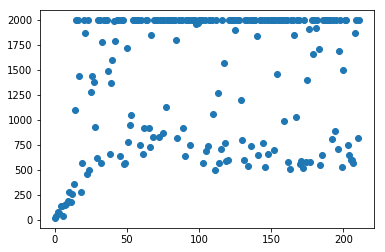

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(len_mem, 'o')

In [48]:
try:
    env.reset()
    env._max_episode_steps = 5000
    for t in count():
        env.render()
        action = get_model_action(model, obs, device, train=False)
        obs, reward, done, info = env.step(action)
        if done:
            env.close()
            break

    print(t)
except KeyboardInterrupt:
    pass
finally:
    env.close()
    print(t)

4999
4999


In [49]:
model.to('cpu')

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): LeakyReLU(negative_slope=0.01, inplace)
  (2): Linear(in_features=8, out_features=2, bias=True)
  (3): Sigmoid()
  (4): Softmax()
)

In [50]:
torch.save(model, 'model.torch')

In [474]:
model = torch.load('model.torch')

In [475]:
model.to(device)

Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): LeakyReLU(negative_slope=0.01, inplace)
  (2): Linear(in_features=32, out_features=2, bias=True)
  (3): Sigmoid()
  (4): Softmax()
)